In [81]:
# %load_ext is safe to repeatedly run in a Jupyter notebook; it will just ignore duplicates.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import Tensor, nn, optim 

# Force reload of the physics module
import importlib
import sys
if 'physics' in sys.modules:
    import physics
    importlib.reload(physics)
    
from physics import ho_variational_loss
from model import MLP
from utils import model_derivative

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Part 1 - Training the Model

### 1️⃣ Hyperparameters and Configuration

In [83]:
# ============================================================================
# 🎛️ CONFIGURATION PARAMETERS
# ============================================================================

# Training hyperparameters
lr              = 1e-3      # Learning rate
epochs          = 6_000     # Number of training epochs
n_points        = 64        # Number of collocation points
log_every       = 800       # Print loss every N epochs

# Physics parameters
omega   = 1.0         # example ω
T_max   = 2*torch.pi
# ============================================================================

torch.manual_seed(0)

# 1. Build the network
model: nn.Module = MLP(hidden=64, device=device) 
model.to(device)
model.eval()        # inference mode (no dropout/BN), BUT gradients on

# 2. Create collocation points in [0, 2 * torch.pi]
t_collocation: Tensor = 2 * torch.pi * torch.rand(n_points, 1, device=device)

# 3. Compute the physics-informed loss
initial_loss = ho_variational_loss(model, t_collocation, omega=omega)
print(f"Initial variational loss: {initial_loss.item():.6f}")

Initial variational loss: 1.233754


### 2️⃣ Training loop

In [84]:
# Increase points for better coverage of the larger window (⚠️ I dont think its that simple!!! ⚠️)
n_points = 256

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_history = []

for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    loss = ho_variational_loss(model, t_collocation, omega=omega)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % log_every == 0 or epoch == 1:
        print(f"epoch {epoch:4d} | loss = {loss.item():.6e}")

epoch    1 | loss = 1.233754e+00
epoch  800 | loss = 1.436062e-05
epoch 1600 | loss = 1.482306e-06
epoch 2400 | loss = 7.216148e-07
epoch 3200 | loss = 1.273646e-07
epoch 4000 | loss = 3.909030e-04
epoch 4800 | loss = 5.713953e-08
epoch 5600 | loss = 4.525625e-07


### 3️⃣ Loss curve

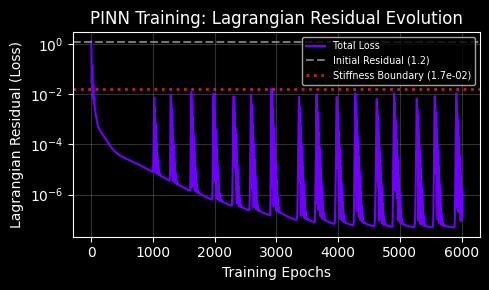

In [85]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, linewidth=1.5, color="#6F00FF", label="Total Loss")

# Baseline: The error of the untrained random model
initial_val = initial_loss.item()
plt.axhline(y=initial_val, color="#A9A9A9", ls="--", alpha=0.7, 
            label=f"Initial Residual ({initial_val:.1f})")

# Stiffness Boundary: The empirical maximum residual after discovery phase
# We look at the peaks after the initial descent (epoch 1000+)
peak_residual = max(loss_history[1000:]) 
plt.axhline(y=peak_residual, color="#E52B50", ls=":", lw=2, alpha=0.8,
            label=f"Stiffness Boundary ({peak_residual:.1e})")

plt.yscale("log")
plt.xlabel("Training Epochs")
plt.ylabel("Lagrangian Residual (Loss)") # More descriptive
plt.title("PINN Training: Lagrangian Residual Evolution")
plt.grid(True, which="both", alpha=0.2)
plt.legend(frameon=True, fontsize='x-small', loc='best')
plt.tight_layout()
plt.savefig("../artifacts/training.png", dpi=200)
plt.show()

### 4️⃣ Compare network vs. analytic solution

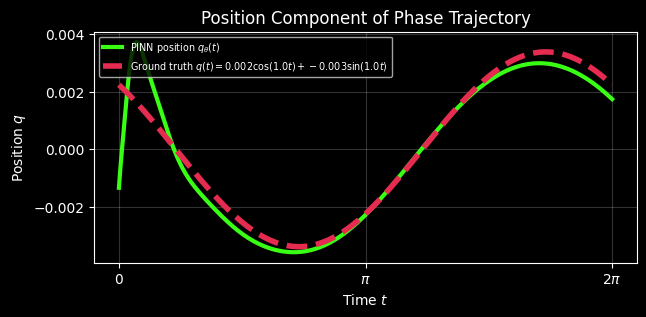

In [86]:
# Dense grid for visualization (extend to 2*T_max to see behavior beyond the training window)
t_dense = torch.linspace(0, T_max, 1000, device=device).view(-1, 1)
with torch.no_grad():
    q_theta_np = model(t_dense).cpu().squeeze()

# Fit the two unknown constants (A, B) of the analytic solution
# q(t) = A * cos(omega*t) + B * sin(omega*t) using least squares.
t_np = t_dense.cpu().numpy()
W_space    = np.column_stack([np.cos(omega * t_np),
                              np.sin(omega * t_np)])
A_B, *_ = np.linalg.lstsq(W_space, q_theta_np.numpy(), rcond=None)    # [A, B]

A, B = A_B
q_exact_np = torch.tensor(W_space @ A_B, dtype=q_theta_np.dtype)

# Plot results
plt.figure(figsize=(7, 3))

plt.plot(t_dense.cpu(), q_theta_np,  label=r"PINN position $q_\theta(t)$", color="#39FF14", lw=3)

ground_truth_label = rf"Ground truth $q(t) = {A:.3f}\cos({omega}t) + {B:.3f}\sin({omega}t)$"
plt.plot(t_dense.cpu(), q_exact_np, label=ground_truth_label, ls="--", color="#E52B50", lw=4)

plt.xlabel(r"Time $t$")
plt.ylabel(r"Position $q$")
plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$']) # Add Pi-ticks!
plt.title("Position Component of Phase Trajectory")

# Place legend at the top, centered
plt.legend(frameon=True, fontsize='x-small', loc='best')

plt.grid(True, which="both", alpha=0.2)
plt.savefig("../artifacts/position_trajectory.png", dpi=200, bbox_inches='tight')
plt.show()

### 1️⃣ Construct Phase Space Grid

In [87]:
# Time grid for model evaluation (use T_max from config)
t = torch.linspace(0, T_max, 400).view(-1, 1)
t.requires_grad_(True)

# Forward pass
q = model(t)

# First derivative: dx/dt = p(t)
dq = torch.autograd.grad(
    q,
    t,
    grad_outputs=torch.ones_like(q),
    create_graph=True,
)[0]

# Phase space grid for model evaluation (NOT collocation points)
q_np = q.detach().cpu().numpy().flatten()
p_np = dq.detach().cpu().numpy().flatten()
t_np = t.detach().cpu().numpy().flatten()

### 2️⃣ Energy Curve

Mean Energy: 1.956465e-05
Energy Std Dev (Wiggles): 7.289077e-05


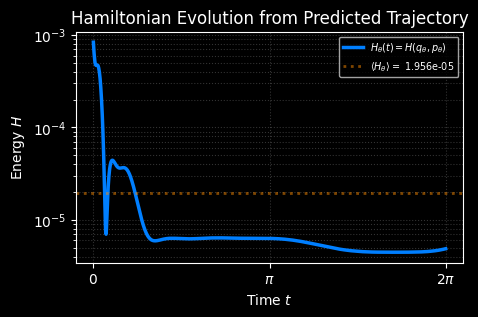

In [88]:
# 1. High-resolution grid for smooth evaluation
t_smooth = torch.linspace(0, 2 * torch.pi, 1000).view(-1, 1).to(device)
t_smooth.requires_grad_(True)

# 2. Re-evaluate model and derivatives
q_smooth = model(t_smooth)
dq_smooth = torch.autograd.grad(
    q_smooth, t_smooth,
    grad_outputs=torch.ones_like(q_smooth),
    create_graph=True,
)[0]

q_s_np = q_smooth.detach().cpu().numpy().flatten()
p_s_np = dq_smooth.detach().cpu().numpy().flatten()
t_s_np = t_smooth.detach().cpu().numpy().flatten()

# 3. Calculate Hamiltonian H_theta(t)
H_smooth = 0.5 * p_s_np**2 + 0.5 * omega**2 * q_s_np**2
h_mean = np.mean(H_smooth)
h_std = np.std(H_smooth)

print(f"Mean Energy: {h_mean:.6e}")
print(f"Energy Std Dev (Wiggles): {h_std:.6e}")

# 4. Plot Hamiltonian
plt.figure(figsize=(5, 3))
plt.plot(t_s_np, H_smooth, color="#007FFF", lw=2.5, antialiased=True, label=r"$H_\theta(t)=H(q_\theta, p_\theta)$")

# Add a dashed line for the mean to show stability
plt.axhline(y=h_mean, color="#FF8C00", ls=":", lw=2, alpha=0.5, label=rf"$\langle H_\theta \rangle=$ {h_mean:.3e}")

plt.grid(True, which="both", alpha=0.2, ls=':')
plt.yscale("log")
plt.legend(frameon=True, fontsize='x-small', loc='best')
plt.xlabel(r"Time $t$")
plt.ylabel(r"Energy $H$")
plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
plt.title("Hamiltonian Evolution from Predicted Trajectory")

plt.savefig("../artifacts/energy.png", dpi=200)
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


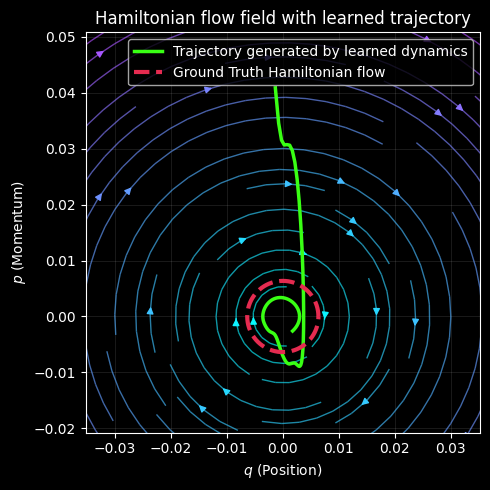

In [89]:
Q, P = np.meshgrid(
    np.linspace(-0.06, 0.06, 20),
    np.linspace(-0.06, 0.06, 20),
)

U = P
V = -omega**2 * Q
speed = np.sqrt(U**2 + V**2)

plt.figure(figsize=(5, 5))

# --- Hamiltonian flow (background) ---
strm = plt.streamplot(
    Q, P, U, V,
    color=speed,
    cmap="cool",
    density=1.1,
    arrowsize=1,
    linewidth=1.0,
)
# Set alpha manually on the line and arrow collections
strm.lines.set_alpha(0.65)
strm.arrows.set_alpha(0.65)

#cbar = plt.colorbar(strm.lines, label="Gradient magnitude")
#cbar.set_ticks([])

# --- Extract Hamiltonian trajectory (reference) ---
H0 = np.mean(0.5 * p_np**2 + 0.5 * omega**2 * q_np**2)
theta = np.linspace(0, 2*np.pi, 400)
r = np.sqrt(2 * H0)

# --- PINN trajectory ---
plt.plot(
    q_np,
    p_np,
    color="#39FF14",
    lw=2.5,
    label=r"Trajectory generated by learned dynamics"
)

# --- Ground Truth trajectory ---
plt.plot(
    r*np.cos(theta)/omega,
    r*np.sin(theta),
    ls="--",
    color="#E52B50",
    lw=3,
    label=r"Ground Truth Hamiltonian flow"
)

# --- Labels & layout
plt.xlabel(r"$q$ (Position)")
plt.ylabel(r"$p$ (Momentum)")

plt.title("Hamiltonian flow field with learned trajectory")

plt.legend(frameon=True)
plt.axis("equal")
plt.xlim(-0.035, 0.035)
plt.ylim(-0.02, 0.05)

plt.tight_layout()
plt.grid(True, which="both", alpha=0.1)
plt.savefig("../artifacts/phase_space.png", dpi=200)
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


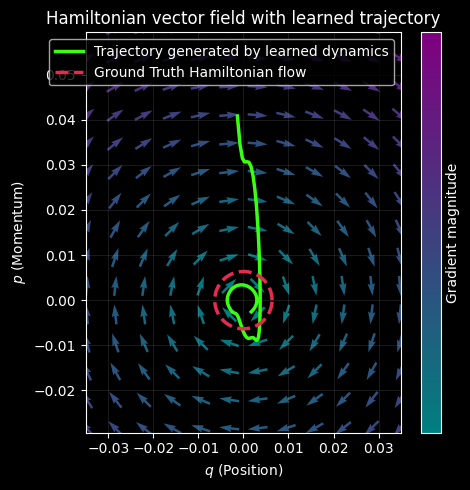

In [90]:
# 1. Setup the grid for the vector field
U = P
V = -omega**2 * Q
speed = np.sqrt(U**2 + V**2)

# Normalize vectors to unit length
U_norm = U / (speed + 1e-10)
V_norm = V / (speed + 1e-10)

plt.figure(figsize=(5, 5))

# 3. Plot the Vector Field (Quiver)
# 'pivot'='mid' centers the arrows on the grid points
vec_field = plt.quiver(Q, P, U_norm, V_norm, speed,
              cmap="cool",
              alpha=0.5,
              width=0.025,
              pivot='mid',
              units='inches',
              scale=5)
cbar = plt.colorbar(vec_field, label="Gradient magnitude")
cbar.set_ticks([])

# 4. Plot Exact Hamiltonian Orbit (Reference)
H0 = np.mean(0.5 * p_np**2 + 0.5 * omega**2 * q_np**2)
theta_grid = np.linspace(0, 2*np.pi, 400)
r_orbit = np.sqrt(2 * H0)

# --- PINN trajectory ---
plt.plot(
    q_np,
    p_np,
    color="#39FF14",
    lw=2.5,
    label="Trajectory generated by learned dynamics"
)

# --- Ground Truth trajectory ---
plt.plot(
    r*np.cos(theta)/omega,
    r*np.sin(theta),
    ls="--",
    color="#E52B50",
    lw=2.5,
    label="Ground Truth Hamiltonian flow"
)

# 6. Final Formatting
plt.xlabel(r"$q$ (Position)")
plt.ylabel(r"$p$ (Momentum)")
plt.title("Hamiltonian vector field with learned trajectory")
plt.legend(frameon=True, loc='best')
plt.axis("equal")

# Set limits based on your existing scale
plt.xlim(-0.035, 0.035)
plt.ylim(-0.02, 0.05)

plt.grid(True, which="both", alpha=0.1)
plt.tight_layout()
plt.savefig("../artifacts/phase_space_quiver.png", dpi=200)
plt.show()